In [1]:
import time
import sys

from graph_nets import blocks
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
from matplotlib import pyplot as plt
from simulate_orbits import *
import numpy as np
from copy import deepcopy

import graph_nets as gn
import sonnet as snt
import tensorflow as tf
import networkx as nx

# For debugging only
#tf.compat.v1.enable_eager_execution()

In [2]:
def get_orbital_velocity(radius, mass_planet, mass_star, G, noise = 0):
    """Calculate the velocity required to keep an orbit

    Parameters
    ---------- 
    radius : float
      the radial distance from the body to the center of the orbit
    mass_planet : float
      mass of the planet orbiting
    mass_star : float
      mass of the body at the center of the orbit
    G : float 
      Gravitational Constant
    noise: float
      The maximum fractional amount by which the initial velocity is perturbed. 
      Defaults to zero

    Returns
    ---------- 
    velocity : float
      the orbital velocity

    """

    velocity = np.sqrt(G*mass_star/radius)

    # Add noise
    if noise > 0:
        delta_vel = rand.uniform(*(-noise,noise), size = np.shape(velocity))
        velocity *= (1.+delta_vel)

    return np.array(velocity)

def get_trajectory(planets, num_time_steps):
    '''
    Calculate real trajectory using Euler integration
    
    Parameters
    ----------
    planets : ls
        A list of planets using the Body class
    num_time_steps : float
        The number of integration steps    
      
    Returns
    -------
    x_traj, p_traj: np.array([num_time_steps, nplanets, 2])
        The positions and momenta of the trajectory for each planet
    '''
    
    nplanets = len(planets)
    x_traj = np.zeros([num_time_steps, nplanets, 2])
    p_traj = np.zeros([num_time_steps, nplanets, 2])
    for i in range(num_time_steps):
        pos = []
        mom = []
        for planet in planets:
            pos.append(planet.orbit[i][0:2])
            mom.append(planet.orbit[i][3:5]*planet.mass)
        
        x_traj[i] = np.array(pos)*AU #km
        p_traj[i] = np.array(mom)*AU/YEAR #km/s

    return x_traj, p_traj

In [3]:
def get_input_graph(planets, xtraj, t, noise_level = 0.05):
    '''
    Convert a given time into a GraphNets graph that can be used to train a model
    
    Parameters
    ----------
    planets : ls
        A list of planets using the Body class
    xtraj: np.array([num_time_steps, nplanets, 2])
        The positions and momenta of the trajectory for each planet
    t: int
        The time at which the trajectory is evaluated
    noise_level: float
        Fractional noise added to the training, defaults to 0.05
        
    Returns
    -------
    graph_dict: dict
        A dictionary containing globals, edges, nodes, senders and receivers
    '''
    nplanets = len(planets)
    nodes, edges, senders, receivers = [], [], [], []
    for i in range(nplanets):
        nodes.append([planets[i].mass/mercury.mass]) #Use Mercury's mass for units to normalize
        for j in range(nplanets):
            # I do this instead of if i != j, so the distances and forces are not duplicate, this
            # improves the model. I am basically telling the model that F(ij)=F(ji)
            if i > j:
                d = xtraj[t,j,:] - xtraj[t,i,:]
                if noise_level > 0:
                    noise = tf.random.normal([2], 0, noise_level, tf.float32) 
                    edges.append(d*(1+noise))
                else:
                    edges.append(d)
 
                receivers.append(i)
                senders.append(j)
    
    return{
      "globals": [G],
      "nodes": nodes,
      "edges": edges, 
      "receivers": receivers, 
      "senders": senders 
    }  

## Integration Functions

In [4]:
def get_distances(x0, nplanets):
    '''
    Convert positions to distances
    '''
    dx = []
    for i in range(nplanets):
        for j in range(nplanets):
            if i > j:
                dx.append(x0[j] - x0[i])
            
    return tf.convert_to_tensor(dx, dtype=np.float32)

def model_gn(dx, num_processing_steps):
    '''
    Use the model to go from dx to dp
    '''
    graph = input_graph_tr.replace(edges=dx)
    outputs = model(graph, num_processing_steps)
    outputs_p = get_momentum_update(outputs)
    output = sum(outputs_p)/num_processing_steps
    dp = output*np.std(dp_traj_np)
    #dp = tf.stack([dp[0], -dp[0]])
    return dp

def get_leapfrog_step(x, ph, dt, planets, model, num_processing_steps):   #(x, ph, dt, m1, m2, model):
    '''
    Perform a step for the leapfrog integration
    '''
    dtm = []
    for planet in planets:
        dtm.append([dt/planet.mass])
    
    deltax=ph*tf.convert_to_tensor(dtm,dtype = np.float32)
    
    x1 = x+deltax

    dx = get_distances(x, len(planets))

    dp = model(dx, num_processing_steps)
    ph3 = ph + dp

    return x1, ph3, dp


def leapfrog_integration(x0, p0, planets,dt, num_steps, model, num_processing_steps):
    '''
    Learn the orbit through leapfrom integration
    '''
    def body(i, x0, p0, x_pred, dp_pred):
        x, ph, dp =  get_leapfrog_step(x0, p0, dt, planets,model, num_processing_steps)
        return i+1, x, ph, x_pred.write(i, x), dp_pred.write(i-1, dp/np.std(dp_traj_np))
    
    # Distance
    dx = get_distances(x0, len(planets))

    # Model predict*norm_p = F*dt
    # (ph = phalf)
    ph = p0 + 0.5*model_gn(dx,  num_processing_steps)
    x = tf.identity(x0)
    
    i = 0

    x_pred = tf.TensorArray(
      dtype=tf.float32, size=num_steps, element_shape=x0.shape)
    dp_pred = tf.TensorArray(
      dtype=tf.float32, size=num_steps-1, element_shape=x0.shape)

    x_pred = x_pred.write(0, x0)
    
    _, _, _, x_pred, dp_pred = tf.while_loop(
    lambda i, *unused_args: i < num_steps,
        body,
        loop_vars = [1, x0, ph, x_pred, dp_pred]
    )
    return x_pred.stack(), dp_pred.stack()

In [5]:
# Global constants
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = 0.1*DAY#/YEAR
total_time = 5000*delta_time
num_time_steps = int(total_time/delta_time)
nplanets = 1
num_processing_steps_tr = 1
patience = 10
d_patience = 1e-4
noise_level = 0.0

# How much time between logging and printing the current results.
log_every_iterations = 10000
num_training_iterations = 1000000

# Mercury with random initial conditions
for i in range(nplanets):
    # Sun
    sun = Body()
    sun.name = 'Sun'
    sun.mass = 1.98892 * 10**30 # kg
    sun.pos = np.zeros(3) # m

    mercury = Body()
    mercury.name = 'Mercury'
    mercury.mass = 0.33011 * 10**24 #kg
    pos_mercury = 0.387*AU
    vel_mercury = get_orbital_velocity(pos_mercury, mercury.mass, sun.mass, G)
    mercury.initiate(pos_mercury, vel_mercury)
    
    venus = Body()
    venus.name = 'Venus'
    venus.mass = 4.8685 * 10**24 #kg
    pos_venus = 0.723*AU
    vel_venus = get_orbital_velocity(pos_venus, venus.mass, sun.mass, G)
    venus.initiate(pos_venus, vel_venus)
    #venus.pos = np.array([0.723 * AU, 0., 0.]) #m
    #venus.vel = np.array([0.,-35.02 * 1000, 0.]) #m/s

    #sun.vel = np.zeros(3)
    sun.vel = -(np.array(mercury.vel)*mercury.mass + np.array(venus.vel)*venus.mass)/sun.mass
    #sun.vel = -np.array(mercury.vel)*mercury.mass/sun.mass
    # Center at zero (improves stability)
    sun.pos = -(np.array(mercury.pos)*mercury.mass + np.array(venus.pos)*venus.mass)/sun.mass
    
    planets = [sun, mercury, venus]
    #planets = [sun, mercury]
    
    sun_gn = deepcopy(sun)
    mercury_gn = deepcopy(mercury)
    venus_gn = deepcopy(venus)
    planets_gn = [sun_gn, mercury_gn, venus_gn]
    #planets_gn = [sun_gn, mercury_gn]

    simulate(planets, total_time, delta_time)
    
x_traj_np, p_traj_np = get_trajectory(planets, num_time_steps)
#x_noise = np.random.normal(0, 0.05, x_traj_np.shape)
#x_traj_np_noisy = x_traj_np*(1+x_noise) 
dp_traj_np = p_traj_np[1:] - p_traj_np[:-1]
#dp_traj_norm = tf.convert_to_tensor(
#    dp_traj_np/np.std(dp_traj_np, axis=(0,2), keepdims=True), dtype=np.float32)

dp_traj_norm = tf.convert_to_tensor(
    dp_traj_np/np.std(dp_traj_np), dtype=np.float32)

x_traj = tf.convert_to_tensor(x_traj_np, dtype=np.float32)
#x_traj_noisy = tf.convert_to_tensor(x_traj_np_noisy, dtype=np.float32)
p_traj = tf.convert_to_tensor(p_traj_np, dtype=np.float32)


Text(0.5, 1.0, 'Graph')

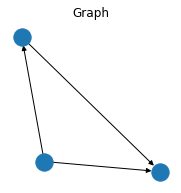

In [6]:
# Generate and visualize a Graph

data_dict = get_input_graph(planets, x_traj,0)
graphs_tuple = utils_np.data_dicts_to_graphs_tuple([data_dict])
graphs_nx = utils_np.graphs_tuple_to_networkxs(graphs_tuple)

ax = plt.figure(figsize=(3, 3)).gca()
nx.draw(graphs_nx[0], ax=ax)
ax.set_title("Graph")

In [7]:
graphs_tuple = utils_tf.data_dicts_to_graphs_tuple([data_dict])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# Get sum over all received nodes for each body

reducer = tf.unsorted_segment_sum
t1 = blocks.ReceivedEdgesToNodesAggregator(reducer=reducer)(graphs_tuple)
t2 = blocks.SentEdgesToNodesAggregator(reducer=reducer)(graphs_tuple)

#with tf.Session() as sess:
#    print(t.eval())

#print(t1)
#print(t2)
#print(t1-t2)

In [9]:
# Create the model.
model = models.EncodeProcessDecode(node_output_size=0, edge_output_size=2, global_output_size=0)

In [10]:
def get_momentum_update(output_ops):
    reducer = tf.unsorted_segment_sum
    
    dp = []
    for output_op in output_ops:
        b1 = blocks.ReceivedEdgesToNodesAggregator(reducer=reducer)(output_op)
        b2 = blocks.SentEdgesToNodesAggregator(reducer=reducer)(output_op)
        dp.append(b1-b2)
    '''
    dp = [
        blocks.ReceivedEdgesToNodesAggregator(reducer=reducer)(output_op)
        for output_op in output_ops]
    '''
    return dp


def create_loss_ops(target_op, output_ops):
    """Create supervised loss operations from targets and outputs.

    Args:
        target_op: The target velocity tf.Tensor.
        output_ops: The list of output graphs from the model.

    Returns:
        A list of loss values (tf.Tensor), one per output op.
    """
    loss_ops = [
        tf.reduce_mean(
            tf.reduce_sum((output_op - target_op)**2, axis=-1))
        for output_op in output_ops
    ]
    return loss_ops

In [11]:
t = tf.random_uniform([], minval=0, maxval=num_time_steps - 1, dtype=tf.int32)
input_dict_tr = get_input_graph(planets, x_traj, t, noise_level = noise_level)
input_graph_tr = utils_tf.data_dicts_to_graphs_tuple([input_dict_tr])
output_model = model(input_graph_tr, num_processing_steps_tr)
output_ops_tr = get_momentum_update(output_model)
target_nodes_tr = dp_traj_norm[t]

# Integration (test)
nsteps_int = 5000
x0 = x_traj[0]
p0 = p_traj[0]
xp, pp = leapfrog_integration(
    x0, p0, planets_gn, delta_time, nsteps_int, model_gn, num_processing_steps_tr)
loss_test = tf.reduce_mean(
    tf.reduce_sum(
    (pp - dp_traj_norm[:nsteps_int-1])**2., axis = -1
    ))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
# Training loss.
loss_ops_tr = create_loss_ops(target_nodes_tr, output_ops_tr)
# Training loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr

In [13]:
# Optimizer.
learning_rate = 1e-5
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

In [14]:
# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
    sess.close()
except NameError:
    pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

nsteps_no_improvement = 0
last_iteration = 0
previous_loss = 0
iterations = []
losses_tr = []
losses_test = []

In [15]:
start_time = time.time()
last_log_time = start_time

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training 1-step loss), ")
      
for iteration in range(last_iteration, num_training_iterations):
    last_iteration = iteration
    train_values = sess.run({
        "step": step_op,
        "loss": loss_op_tr,
        "input_graph": input_graph_tr,
        "target_nodes": target_nodes_tr,
        "outputs": output_ops_tr
    })
    the_time = time.time()
    
    if train_values["loss"] >= (previous_loss - d_patience): 
        nsteps_no_improvement += 1
    else: 
        nsteps_no_improvement = 0
    
    previous_loss = train_values["loss"]
        
    if nsteps_no_improvement >= patience: 
        print('Convergence achieved')
        print('Iterations = ', iteration)
        print('Time = ', time.time() - start_time, 'seconds.')
        print('Training 1-step loss = ', train_values["loss"])
        break
    
    if iteration%log_every_iterations == 0:
        test_orbit = sess.run({
            "x_pred": xp, 
            "loss": loss_test
        })
        last_log_time = the_time
        elapsed = time.time() - start_time
        iterations.append(iteration)
        losses_tr.append(train_values["loss"])
        losses_test.append(test_orbit["loss"])
        print(
            "# {:07d}, T {:.1f}, Ltr {:.8f}, Ltest {:.8f}".format(
                iteration, elapsed, train_values["loss"], test_orbit["loss"]))

# (iteration number), T (elapsed seconds), Ltr (training 1-step loss), 
# 0000000, T 1.1, Ltr 2.85885644, Ltest 3.22225165
# 0010000, T 12.2, Ltr 1.02215004, Ltest 3.06293631
# 0020000, T 22.8, Ltr 0.45652151, Ltest 1.49778175
# 0030000, T 33.2, Ltr 0.03690869, Ltest 0.32345766
# 0040000, T 43.6, Ltr 0.01514183, Ltest 0.14185856
# 0050000, T 54.4, Ltr 0.00407798, Ltest 0.02811837
# 0060000, T 65.1, Ltr 0.00405324, Ltest 0.06721453
# 0070000, T 75.6, Ltr 0.00274712, Ltest 0.07679030
# 0080000, T 86.9, Ltr 0.00304874, Ltest 0.00997031
# 0090000, T 98.9, Ltr 0.00314916, Ltest 0.05422049
# 0100000, T 111.0, Ltr 0.00086143, Ltest 0.03657261
# 0110000, T 123.6, Ltr 0.00097545, Ltest 0.02455924
# 0120000, T 135.2, Ltr 0.00042602, Ltest 0.02605756
# 0130000, T 146.7, Ltr 0.00032339, Ltest 0.01332667
# 0140000, T 157.7, Ltr 0.00010861, Ltest 0.00820223
# 0150000, T 169.4, Ltr 0.00062508, Ltest 0.01117810
# 0160000, T 181.3, Ltr 0.00016474, Ltest 0.00846963
Convergence achieved
Iterations =  160

## Plots

Text(0, 0.5, 'Test loss')

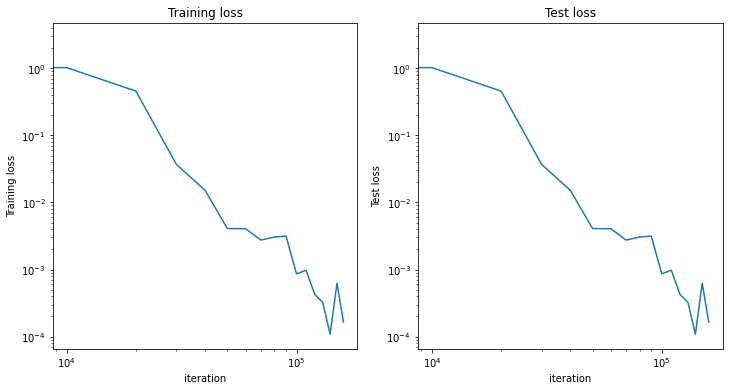

In [16]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (12, 6))

ax = axs[0]
ax.plot(iterations,losses_tr)
ax.set_title('Training loss')
ax.set_xlabel('iteration')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Training loss')

ax = axs[1]
ax.set_title('Test loss')
ax.plot(iterations,losses_tr)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('Test loss')

In [17]:
# Get prediction as numpy array
x_pred = test_orbit["x_pred"]

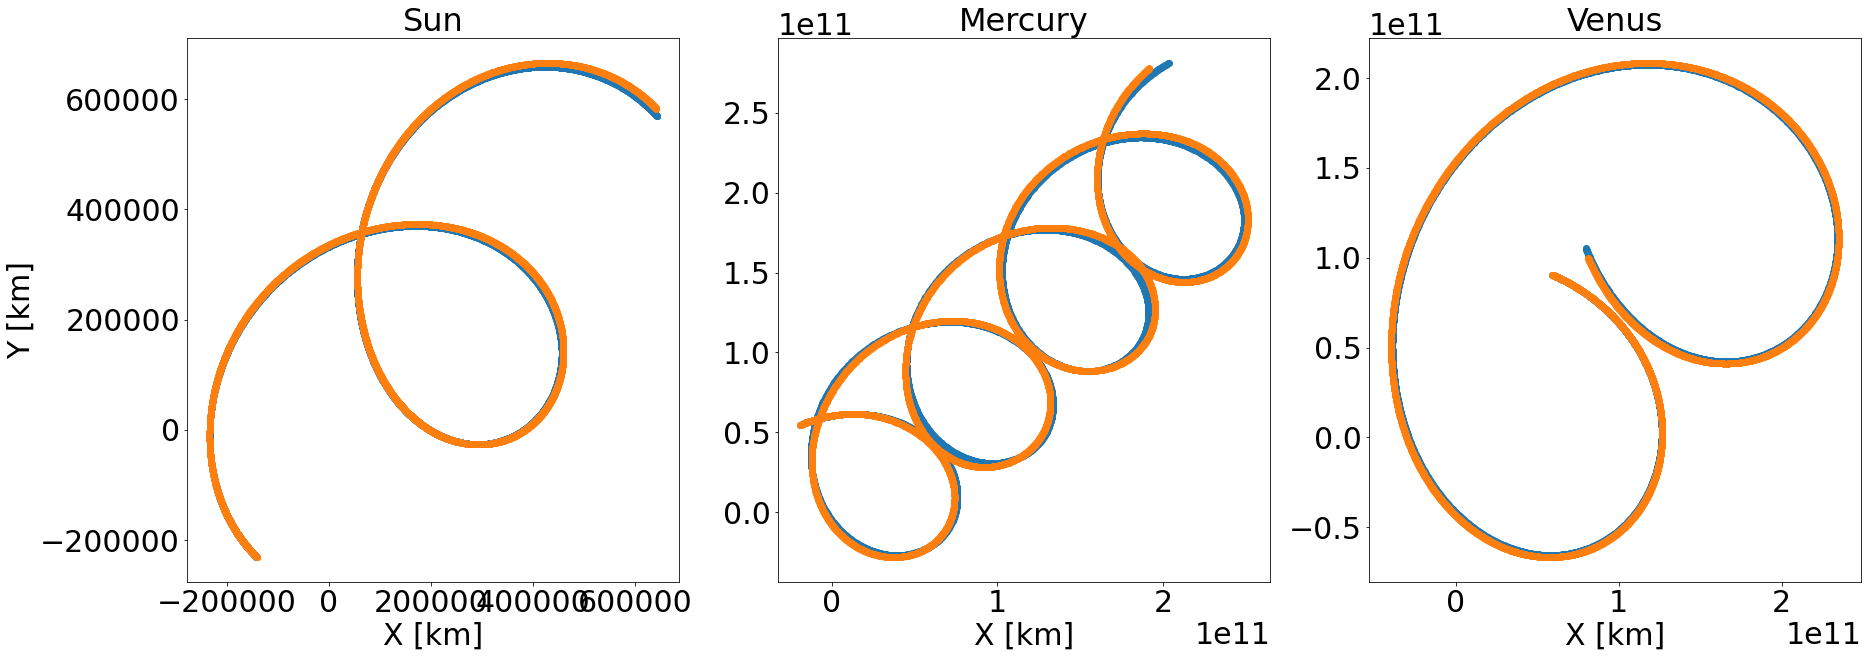

In [26]:
nsteps_plot = 3500
plt.rcParams.update({'font.size': 30})
fig, axs =plt.subplots(nrows = 1, ncols = len(planets), figsize = (30, 10))

periods = np.array([225, 88, 225])
factor = 10*periods

axs[0].set_ylabel('Y [km]')
for i in range(len(planets)):
    ax = axs[i]
    
    shift = x_traj_np[:,i,0].max()/factor[i]*np.arange(nsteps_plot)

    ax.set_title(planets[i].name, fontsize = 32)
    ax.scatter(x_traj_np[:nsteps_plot,i,0]+shift, x_traj_np[:nsteps_plot,i,1]+shift, label='Truth')
    ax.scatter(x_pred[:nsteps_plot,i,0]+shift, x_pred[:nsteps_plot,i,1]+shift, label='Prediction')
    ax.set_xlabel('X [km]')
    
    
plt.savefig('/Users/Pablo/Desktop/orbits')